# Compare Community First and Awards for All

Following the separate analysis of the Community First and Awards for All funds, this takes the [pickled](https://docs.python.org/3.6/library/pickle.html) datasets and merges them, and then runs some comparison graphs on them.

First import the needed python libraries, including charting libraries

In [1]:
from __future__ import print_function # helps with python 2 compatability
import pandas as pd       # Pandas data analysis library

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')
from matplotlib.ticker import FuncFormatter
import numpy as np

Get data from pickles and merge into a single dataframe.

In [59]:
g = pd.concat([
    pd.read_pickle("afa.pkl"),
    pd.read_pickle("cf.pkl")
])

## Cleaning and transforming data

Restrict the data to just three fiscal years

In [60]:
g = g[g["Grant Fiscal Year"].isin([2012,2013,2014])]

Add the name of the fund as a variable

In [61]:
funds = {
    "Cabinet Office": "Community First",
    "The Big Lottery Fund": "Awards for All"
}
g.loc[:,"Fund:Name"] = g.loc[:,"Funding Org:Name"].map(lambda x: funds[x])

The local authority field is inconsistent - it's held in `Beneficiary Location:1:Geographic Code` in the Community First data and `Recipient Org:Location:1:Geographic Code` in the Big Lottery Fund data. This merges both fields into one that can be used to repeat the index of multiple deprivation analysis.

In [62]:
la_code_fields = [
    ("Cabinet Office", "Beneficiary Location:1:Geographic Code"),
    ("The Big Lottery Fund", "Recipient Org:Location:1:Geographic Code")
]
g.loc[:,"lacode"] = None
for la_code_field in la_code_fields:
    g.loc[g["Funding Org:Name"]==la_code_field[0],"lacode"] = g.loc[g["Funding Org:Name"]==la_code_field[0], la_code_field[1]]

## Analysis

### Basic comparison

We'll start by comparing the number of grants in each fund. 

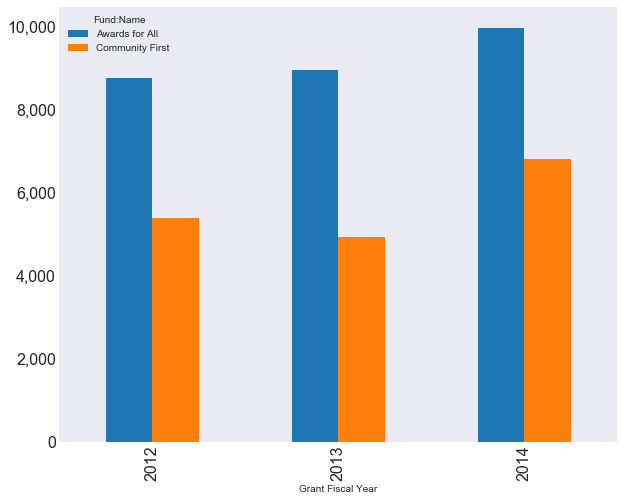

In [63]:
ax = pd.crosstab(index=g["Grant Fiscal Year"], columns=g["Fund:Name"], values=g["Amount Awarded"], aggfunc="count")\
    .plot(kind="bar", figsize=(10,8), fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:,.0f}'.format(y)))

Then look at the total amount awarded by each fund.

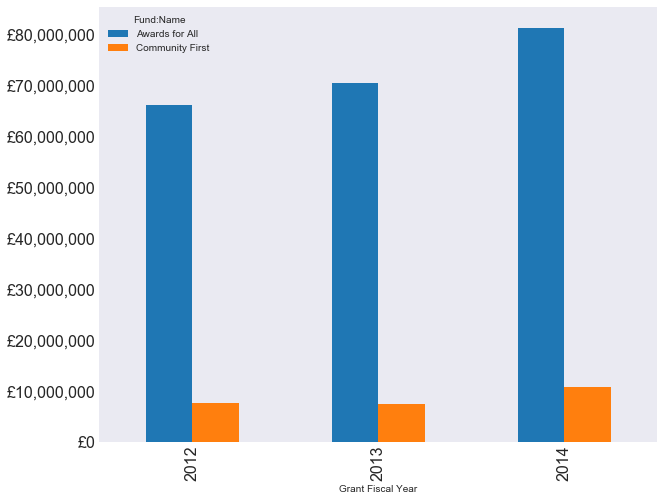

In [64]:
ax = pd.crosstab(index=g["Grant Fiscal Year"], columns=g["Fund:Name"], values=g["Amount Awarded"], aggfunc="sum")\
    .plot(kind="bar", figsize=(10,8), fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '£{:,.0f}'.format(y)))

And finally the mean average amount awarded by each fund.

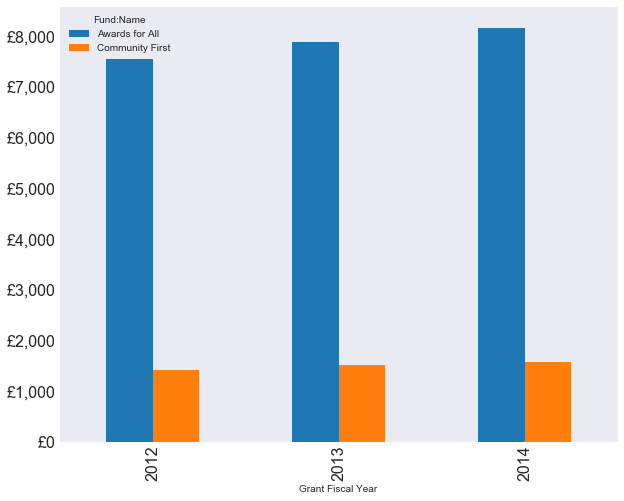

In [65]:
ax = pd.crosstab(index=g["Grant Fiscal Year"], columns=g["Fund:Name"], values=g["Amount Awarded"], aggfunc="mean")\
    .plot(kind="bar", figsize=(10,8), fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '£{:,.0f}'.format(y)))

In [66]:
g.groupby("Fund:Name")["Amount Awarded"].agg(["sum","count","mean","median"])

,sum,count,mean,median
Fund:Name,,,,
Awards for All,2.180430e+08,27673,7879.270219,9450.0
Community First,2.585573e+07,17137,1508.766250,1500.0


### Deprivation analysis

Repeating the analysis of index of multiple deprivation (by local authority) that was done in the separate analyses.

First load the data and merge into a separate dataset.

In [68]:
imd_data = pd.read_csv("imd.csv")
imd_data.shape

(22168, 6)

In [69]:
imd_rank = imd_data[(imd_data["Measurement"]=="Rank of average score") 
         & (imd_data["Indices of Deprivation"]=="a. Index of Multiple Deprivation (IMD)")]\
        [["GeographyCode", "Value"]].set_index("GeographyCode")["Value"]
imd_rank = pd.qcut(imd_rank, 10)
imd_rank = imd_rank.cat.rename_categories(range(0,10))
imd_rank.name = "IMD Rank"

In [70]:
imd_merge = g.merge(pd.DataFrame(imd_rank), left_on="lacode", right_index=True)

Look at the distribution by fund by IMD decile.

In [71]:
imd_ranks = pd.crosstab(index=imd_merge["IMD Rank"], 
            columns=imd_merge["Fund:Name"], 
            values=imd_merge["Amount Awarded"], 
            aggfunc="count",
            normalize="columns")
imd_ranks.applymap('{:.1%}'.format)

Fund:Name,Awards for All,Community First
IMD Rank,,
0,22.6%,38.0%
1,17.2%,26.1%
2,13.9%,16.6%
3,7.5%,7.0%
4,8.3%,5.7%
5,8.5%,3.2%
6,6.2%,2.1%
7,6.8%,0.5%
8,5.3%,0.5%


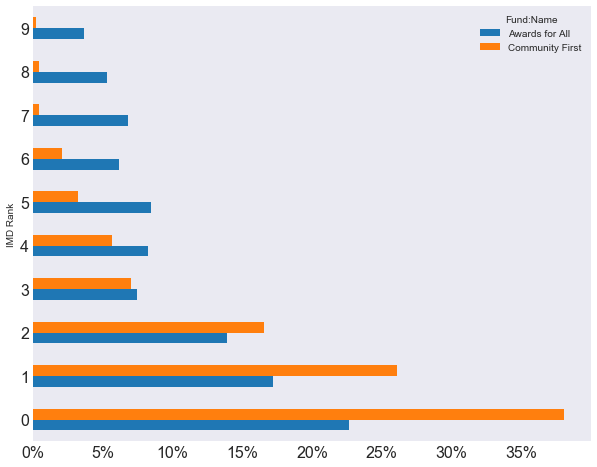

In [72]:
ax = imd_ranks.plot(kind="barh", figsize=(10,8), fontsize=16)
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

### Charity analysis

Using the charity data added to both datasets, show some data about the charities that received funds.

In [73]:
classes = {
    "Themes": ['GENERAL CHARITABLE PURPOSES',
       'EDUCATION/TRAINING', 'THE ADVANCEMENT OF HEALTH OR SAVING OF LIVES',
       'DISABILITY', 'THE PREVENTION OR RELIEF OF POVERTY',
       'OVERSEAS AID/FAMINE RELIEF', 'ACCOMMODATION/HOUSING',
       'RELIGIOUS ACTIVITIES', 'ARTS/CULTURE/HERITAGE/SCIENCE',
       'AMATEUR SPORT', 'ANIMALS', 'ENVIRONMENT/CONSERVATION/HERITAGE',
       'ECONOMIC/COMMUNITY DEVELOPMENT/EMPLOYMENT',
       'ARMED FORCES/EMERGENCY SERVICE EFFICIENCY',
       'HUMAN RIGHTS/RELIGIOUS OR RACIAL HARMONY/EQUALITY OR DIVERSITY',
       'RECREATION', 'OTHER CHARITABLE PURPOSES'],
    "Beneficiaries": ['CHILDREN/YOUNG PEOPLE',
       'ELDERLY/OLD PEOPLE', 'PEOPLE WITH DISABILITIES',
       'PEOPLE OF A PARTICULAR ETHNIC OR RACIAL ORIGIN',
       'OTHER CHARITIES OR VOLUNTARY BODIES', 'OTHER DEFINED GROUPS',
       'THE GENERAL PUBLIC/MANKIND'],
    "Activities": ['MAKES GRANTS TO INDIVIDUALS',
       'MAKES GRANTS TO ORGANISATIONS', 'PROVIDES OTHER FINANCE',
       'PROVIDES HUMAN RESOURCES', 'PROVIDES BUILDINGS/FACILITIES/OPEN SPACE',
       'PROVIDES SERVICES', 'PROVIDES ADVOCACY/ADVICE/INFORMATION',
       'SPONSORS OR UNDERTAKES RESEARCH',
       'ACTS AS AN UMBRELLA OR RESOURCE BODY', 'OTHER CHARITABLE ACTIVITIES']
}

Get the total number of charities in both funds

In [74]:
no_chars = g[g[[j for i in classes for j in classes[i]]].sum(axis=1)>0]["Fund:Name"].value_counts()
no_chars["Total"] = no_chars.sum()
no_chars

Awards for All      8745
Community First     2086
Total              10831
Name: Fund:Name, dtype: int64

Proportion of each fund that went to charities.

In [75]:
pd.crosstab(g["Fund:Name"], g['Recipient Org:Charity Number_y'].notnull(), normalize="index").applymap('{:,.1%}'.format)

Recipient Org:Charity Number_y,False,True
Fund:Name,,
Awards for All,63.2%,36.8%
Community First,87.6%,12.4%


Comparison of the "theme" of recipient charities

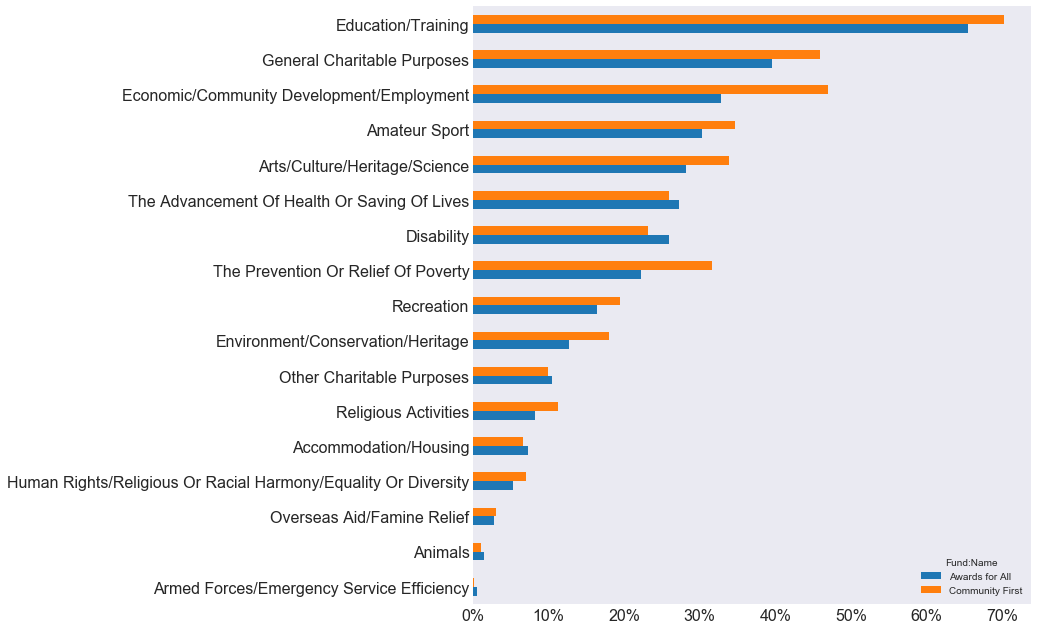

In [76]:
classes_count = g[classes["Themes"] + ["Fund:Name"]].groupby("Fund:Name").sum()
classes_count.loc["Total",:] = classes_count.sum()
classes_count.columns = classes_count.columns.map(str.title)
classes_pc = classes_count.transpose().apply(lambda x: x / no_chars[x.index], axis=1)\
    .sort_values("Total", ascending=True).drop("Total", axis=1)
classes_ax = classes_pc.plot(kind="barh", figsize=(10,11), fontsize=16, stacked=False)
classes_ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

Comparison of the beneficiaries of recipient charities

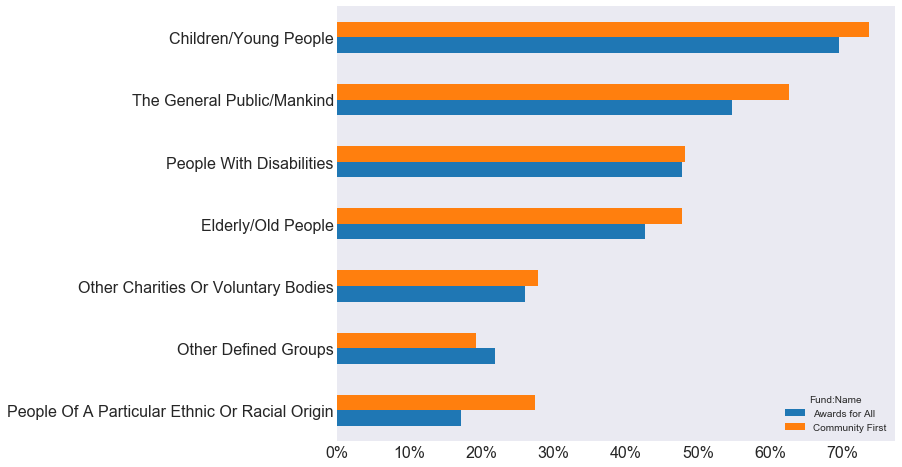

In [77]:
classes_count = g[classes["Beneficiaries"] + ["Fund:Name"]].groupby("Fund:Name").sum()
classes_count.loc["Total",:] = classes_count.sum()
classes_count.columns = classes_count.columns.map(str.title)
classes_pc = classes_count.transpose().apply(lambda x: x / no_chars[x.index], axis=1)\
    .sort_values("Total", ascending=True).drop("Total", axis=1)
classes_ax = classes_pc.plot(kind="barh", figsize=(10,8), fontsize=16, stacked=False)
classes_ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

Comparison of the activities of recipient charities.

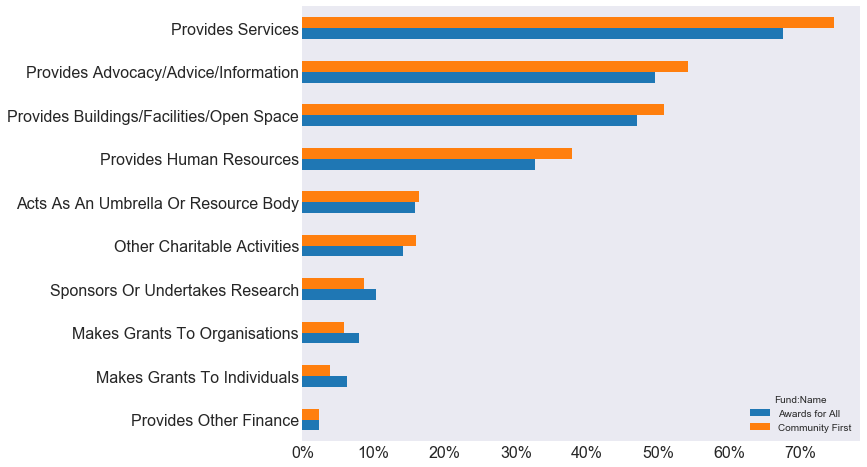

In [78]:
classes_count = g[classes["Activities"] + ["Fund:Name"]].groupby("Fund:Name").sum()
classes_count.loc["Total",:] = classes_count.sum()
classes_count.columns = classes_count.columns.map(str.title)
classes_pc = classes_count.transpose().apply(lambda x: x / no_chars[x.index], axis=1)\
    .sort_values("Total", ascending=True).drop("Total", axis=1)
classes_ax = classes_pc.plot(kind="barh", figsize=(10,8), fontsize=16, stacked=False)
classes_ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

## Funds overlap

Look for organisations that have received grants from both funds.

We start by grouping on recipient name and local authority. 

In [79]:
nodes = g.groupby(["Recipient Org:Name","lacode","Fund:Name"])["Amount Awarded"].count().unstack().fillna(0)

Then add a field showing whether they've been funded by one or the other or both.

In [80]:
nodes.loc[(nodes["Awards for All"]>0) & (nodes["Community First"]>0), "Funds"] = "Both"
nodes.loc[(nodes["Awards for All"]>0) & (nodes["Community First"]==0), "Funds"] = "Awards for All"
nodes.loc[(nodes["Awards for All"]==0) & (nodes["Community First"]>0), "Funds"] = "Community First"
b = nodes["Funds"].value_counts()
b

Awards for All     24738
Community First    12493
Both                 517
Name: Funds, dtype: int64

In [93]:
b.sum()

37748

Proportion funded by one or other or both.

In [94]:
b / b.sum()

Awards for All     0.655346
Community First    0.330958
Both               0.013696
Name: Funds, dtype: float64

Then use matplotlib_venn (install using `pip install matplotlib-venn`) to draw a venn diagram.

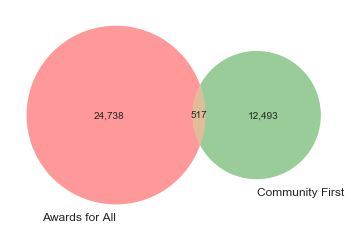

In [81]:
from matplotlib_venn import venn2
set_labels = ["Awards for All", "Community First", "Both"]
venn2(subsets = [b[i] for i in set_labels], set_labels=set_labels, subset_label_formatter='{:,.0f}'.format)

This crosstab shows the number of grants each organisation has received from the two funds.

In [95]:
pd.crosstab(nodes["Community First"], nodes["Awards for All"])

Awards for All,0.0,1.0,2.0,3.0,4.0
Community First,,,,,
0.0,0,22696,1959,81,2
1.0,9925,261,28,1,0
2.0,1824,98,18,0,0
3.0,510,60,12,0,0
4.0,157,15,0,1,0
5.0,41,13,0,0,0
6.0,20,2,2,0,0
7.0,7,1,1,0,0
8.0,4,0,2,0,0
